# Online Robust PCA

### Tom Furnival ([tjof2@cam.ac.uk](mailto:tjof2@cam.ac.uk))

*14th July 2016*

A key assumption of using Principal Component Analysis (PCA) for denoising and dimensionality reduction is that the underlying data is corrupted by a small amount of Gaussian noise. As a result, PCA is very sensitive to large errors, such as X-ray spikes, dead pixels or even missing data.

Robust PCA (RPCA) was introduced to overcome this problem [1]. It decomposes a corrupted dataset **Y** into a low-rank component **X** and a sparse error component **E**, i.e. **Y** = **X** + **E**.

This notebook is a demonstration of the Online Robust PCA (ORPCA) algorithm [2], as implemented in HyperSpy, which is able to recover the low-rank component of a corrupted matrix in a memory-efficient manner that is suitable for "big data". In particular, the algorithm updates the low-rank estimate as each observation arrives, avoiding the expensive re-calculation associated with batch methods.


[1] E. J. Candes et al, *Robust Principal Component Analysis?*,
(2009).<br/>URL: [https://statweb.stanford.edu/~candes/papers/RobustPCA.pdf](https://statweb.stanford.edu/~candes/papers/RobustPCA.pdf)

[2] J. Feng, H. Xu and S. Yan, *"Online Robust PCA via Stochastic Optimization"*, (2013).<br/>
URL: [https://papers.nips.cc/paper/5131-online-robust-pca-via-stochastic-optimization](https://papers.nips.cc/paper/5131-online-robust-pca-via-stochastic-optimization)

In [2]:
#Download the data (1MB)
from urllib.request import urlretrieve, urlopen
from zipfile import ZipFile
files = urlretrieve("https://www.dropbox.com/s/ecdlgwxjq04m5mx/HyperSpy_demos_EDS_TEM_files.zip?raw=1", "./HyperSpy_demos_EDX_TEM_files.zip")
with ZipFile("HyperSpy_demos_EDX_TEM_files.zip") as z:
    z.extractall()

# Set up HyperSpy
%matplotlib nbagg
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt



## 1. Normal PCA+ICA

In the first instance, we follow the routine described in [this HyperSpy tutorial](https://github.com/hyperspy/hyperspy-demos/blob/master/electron_microscopy/EDS/TEM_EDS_Tutorial_HyperSpy_CoreShellNanoparticles.ipynb), which carries out the standard PCA decomposition to reduce noise, followed by BSS with a known number of components (3).

<IPython.core.display.Javascript object>


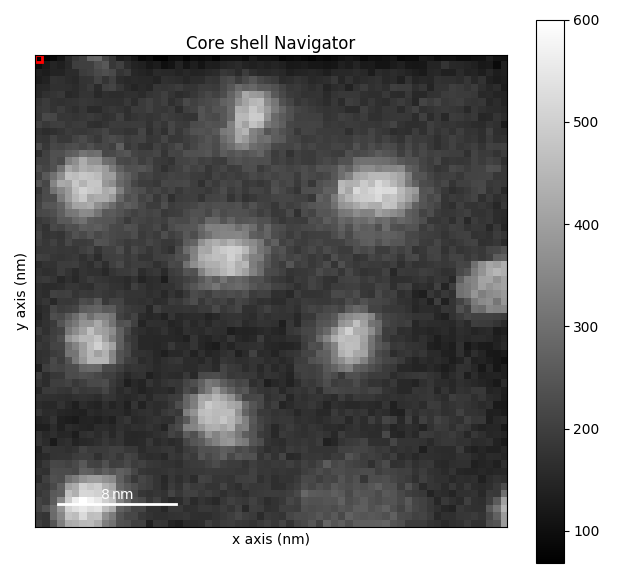

<IPython.core.display.Javascript object>


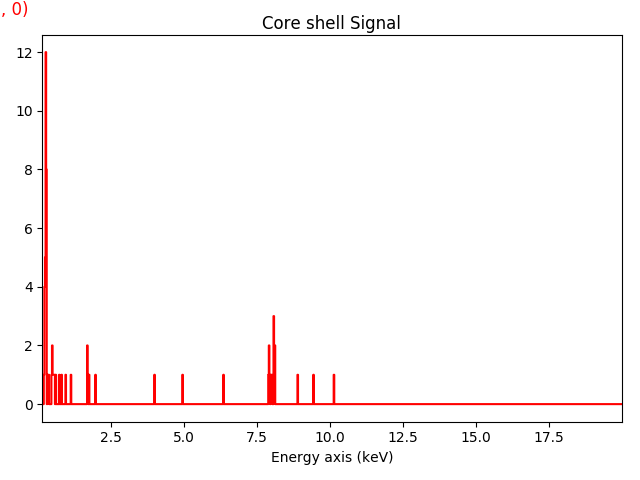

<IPython.core.display.Javascript object>


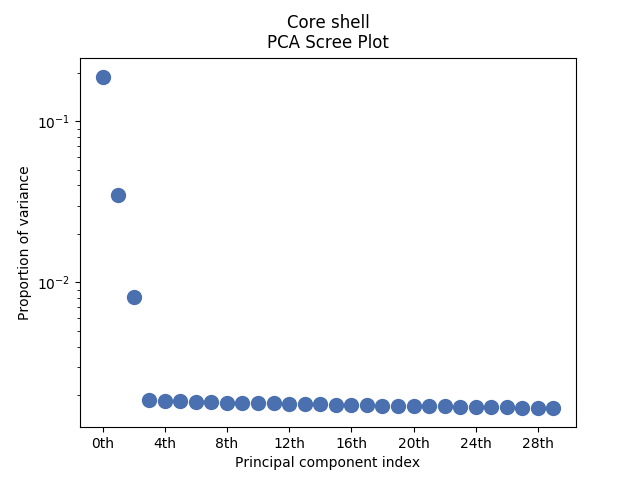

<IPython.core.display.Javascript object>


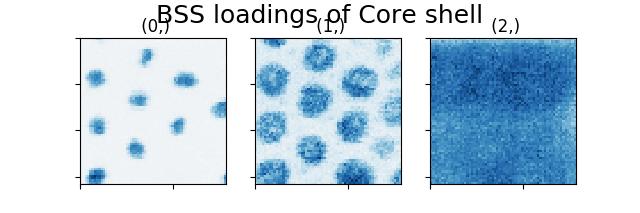

In [3]:
# Load data
cs = hs.load('core_shell.hdf5')
cs.change_dtype('float')
cs.plot()

# Apply PCA
cs.decomposition()
cs.plot_explained_variance_ratio()

# Apply ICA
cs.blind_source_separation(3)
axes = hs.plot.plot_images(cs.get_bss_loadings(), axes_decor=None, cmap='RdBu', colorbar=None)

## 2. Normal PCA+ICA on corrupted data

Now we corrupt the data with sparse errors to simulate e.g. hot pixels or X-ray spikes. We apply the corruption by masking 5% of the datapoints with the value 1000.

<IPython.core.display.Javascript object>


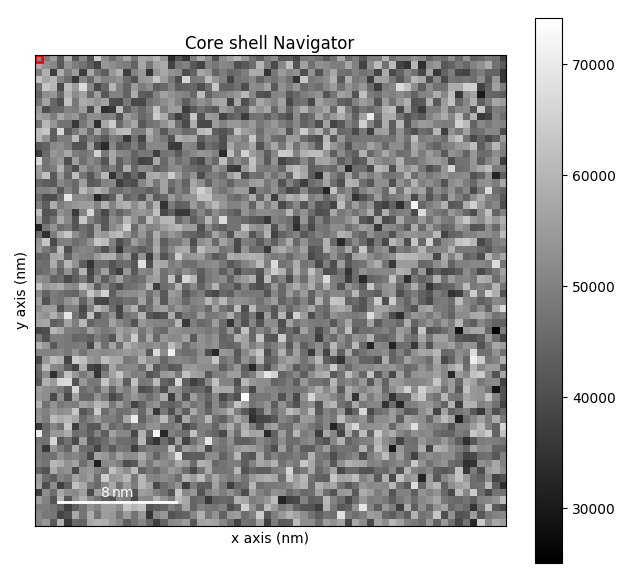

<IPython.core.display.Javascript object>


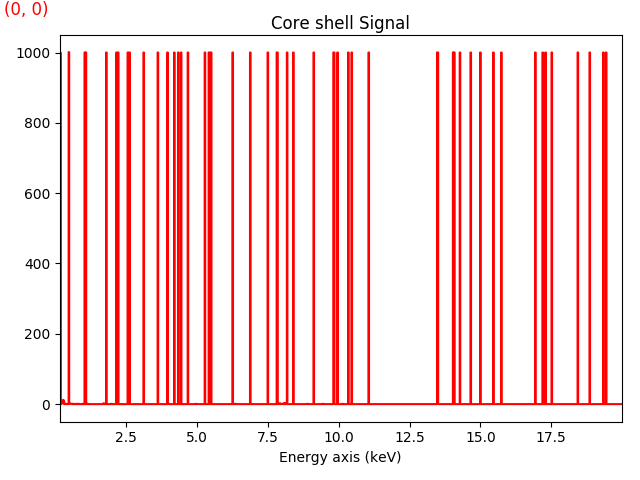

In [4]:
# Corrupt the data with sparse errors
sparse = 0.05 # Fraction of corrupted data

cserror = cs.copy()
E = 1000 * np.random.binomial(1, sparse, cs.data.shape)
cserror.data = cserror.data + E

cserror.plot()

As discussed above, PCA is known to be sensitive to outliers, so first we try the same PCA+ICA analysis. Notice how the scree plot is dominated by the sparse errors and so is tricky to interpret. The BSS results are essentially noise.

<IPython.core.display.Javascript object>


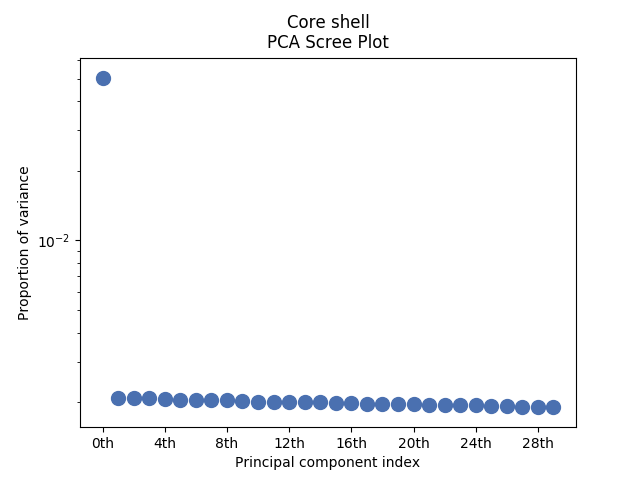

<IPython.core.display.Javascript object>


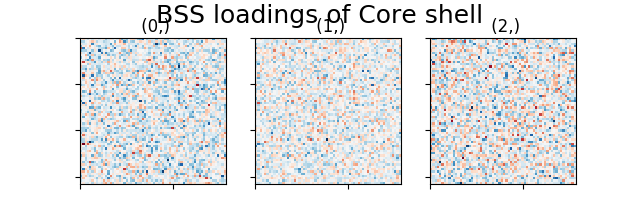

In [5]:
# Apply PCA
cserror.decomposition()
cserror.plot_explained_variance_ratio()

# Apply ICA
cserror.blind_source_separation(3)
axes = hs.plot.plot_images(cserror.get_bss_loadings(), axes_decor=None, cmap='RdBu', colorbar=None)

## 3. Online Robust PCA+ICA on corrupted data

Now we try the ORPCA algorithm on the same corrupted data, followed by ICA. 

- `output_dimension` is an initial estimate of the rank of the data
- `init` is the initialization method, which can be<br>- `rand` (random), or<br>- `qr` (QR-decomposition based) - **default**
- `lambda1` is the nuclear norm regularization parameter
- `lambda2` is the sparse error regularization parameter

Here we set `normalize_poissonian_noise=False`, although this option may depend on your data.

Interpreting the scree plot is much more straightforward, and the results of the BSS match the originals seen above.

<IPython.core.display.Javascript object>


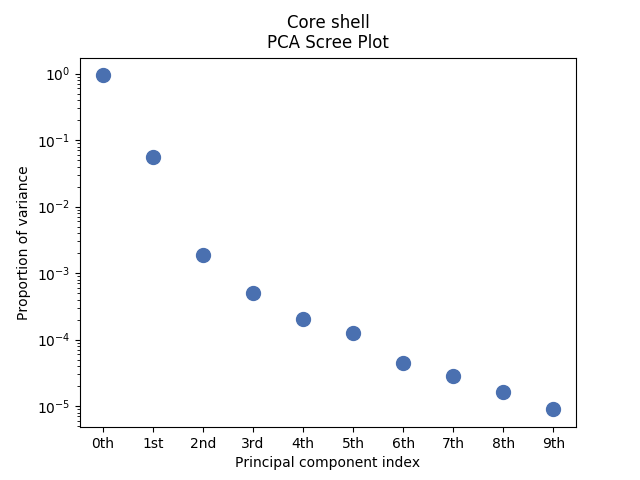

<IPython.core.display.Javascript object>


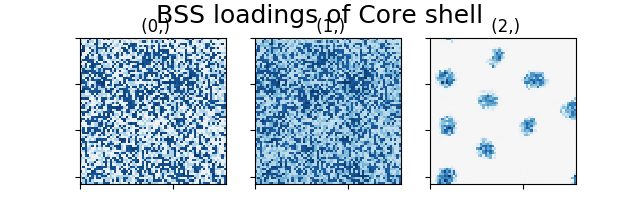

In [6]:
# Try online robust PCA
cserror.decomposition(normalize_poissonian_noise=False,
                      algorithm='ORPCA',
                      output_dimension=10,                  
                      init='rand',                      
                      lambda1=0.005,
                      lambda2=0.005)
cserror.plot_explained_variance_ratio()

# Apply ICA
cserror.blind_source_separation(3)
axes = hs.plot.plot_images(cserror.get_bss_loadings(), axes_decor=None, cmap='RdBu', colorbar=None)